In [1]:
### ========= SIAMESE NETWORK CODE FOR SUBJECT MATCHING (MNIT Dataset) =======
## Note. This run on GPU


### --------- IMPORT PACKAGES
import torch
import torch.nn as nn
import torch.nn.functional as F
#data handling
import numpy as np
import random
#plotting
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
#datasets
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torch import optim
from torch.utils.data import random_split
#ROC AUC curve
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F
#image loading
from google.colab import files
from PIL import Image, ImageOps
import io
#save on drive
from google.colab import drive


### --------- CLASSES DEFINTIONS

## --- PAIRED IMAGES DATASET BUILDING
class SiameseData(Dataset):
    ''' Define a custom class (dataset + transform) to build a Siamese (i.e paired imaged) datatset
    starting from a given dataset and a given transform.
    Returns img1, img2 and the matching label
    '''
    #stores the dataset and optional transform for later use
    def __init__(self, data, transform=None):
        # Save the dataset (e.g., training or validation set) as an instance variable
        self.data = data
        # Save the transform as an instance variable
        self.transform = transform

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.data)

    #returns 1 sample (pair of imgs) given an index
    def __getitem__(self,index):
        #select img1 and its label
        img1, label1 = self.data[index]

        #randomly decide if picking a matching label (same class = 1) or different labels (same class = 0) pair
        same_class = random.randint(0, 1)

        # the pair MUST have a matching label (same class)
        if same_class == 1:
            #initilize label2 (with a value not included in MNIST (goes from 0-9))
            label2 = -1
            #loop to keep picking until a label match is found (stops when label2 == label1)
            while label2 != label1:
                #randomly picks and img and its label to compare with label1
                img2, label2 = random.choice(self.data)

        #the pair MUST NOT have a matching label (different classes)
        else:
            #initilize label 2 = label1
            label2 = label1
            #loop to keep picking until a different label pic is found (stops when label2 != label1)
            while label2 == label1:
                #randomly picks and img and its label to compare with label1
                img2, label2 = random.choice(self.data)

        # once a an img2 (either = or different) has been found transform both the imgs
        if self.transform: #(if a transform was defined)
            #apply transform to img1
            img1 = self.transform(img1)
            #apply transform to img2
            img2 = self.transform(img2)

        #define the pair_label (1 if labels differ, else 0 (base case))
        pair_label = torch.tensor([(label1 != label2)], dtype = torch.float32)
        #check if labels are different, if are the output is True -> pytorch converts to 1

        #return imgs pair and their label
        return img1, img2, pair_label


## --- CONVOLUTIONAL NEURAL NETWORK DEFINITION
class SiameseNetwork(nn.Module):
    ''' Define a siamese neural network to extract features from images
    '''
    #initialize the base nn.module class
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # (3) convolutional layers to extract features from img
        self.cnn = nn.Sequential(
            #1st layer
            nn.Conv2d(1, 64, kernel_size = 5, stride = 1, padding = 2), #1 input channel -> 64 output channels
            nn.ReLU(inplace = True), #RELU activation function
            nn.MaxPool2d(2, stride = 2), #max pooling downsampling

            #2nd layer
            nn.Conv2d(64, 128, kernel_size = 5, stride = 1, padding = 2), #64 input channels -> 128 outpts channels
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            #3rd layer (smaller filter size, same pixel moving each step, smaller border )
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1), #128 input channels -> 256 outpts channels
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)
        )

        # Fully connected layers to convert CNN features into embeddings
        self.fc = nn.Sequential(
            #flats the CNN output and maps it to 1024 features
            nn.Linear(256 * 3 * 3, 1024),
            #apply ReLU activation
            nn.ReLU(inplace = True),

            #reduces dimensionality (to 256)
            nn.Linear(1024, 256),
            #activation function
            nn.ReLU(inplace = True),
            #final embedding to 2, used to compute distances
            nn.Linear(256,2)
        )

    #compute the embedding for 1 img
    def forward_once(self, x):
        #pass the img to the cnn to extract features
        output = self.cnn(x)
        #flat the cnn output into a 1D vector x img
        output = output.view(output.size()[0], -1)
        #pass through fully connected layers to get the embedding
        output = self.fc(output)
        #get the output
        return output

    #compute the embedding for an imgs PAIR (used to measure similarity)
    def forward(self, input1, input2):
        #get embedding on the 1st img
        output1 = self.forward_once(input1)
        #get embedding on the 2nd img
        output2 = self.forward_once(input2)
        #get embedding for both imgs
        return output1, output2


## --- CONTRASTIVE LOSS FUNCTION (custom loss function class for contrastive learning)
class ContrastLoss(torch.nn.Module):
    # Initialize the class, setting a 'margin' (minimum distance between embeddings of different classes)
    def __init__(self, margin = 2.0):
        # Inherit from PyTorch's base class for all neural network modules
        super(ContrastLoss, self).__init__()
        # Save the margin as an attribute of the loss function
        self.margin = margin

    # Define how the loss is computed for each batch
    def forward(self, output1, output2, y):
        # Compute the Euclidean distance  (between the two outputs)
        euclid_dist = F.pairwise_distance(output1, output2, keepdim = True)

        #similar pairs (y = 0): minimize the squared distance between embeddings
        same_class_loss = (1 - y) * (euclid_dist ** 2)

        # different pairs (y = 1): penalize only if the distance is smaller than the margin
        diff_class_loss = (y) * (torch.clamp(self.margin - euclid_dist, min = 0.0) ** 2)
        # Note. this encourages diff pairs to be at least 'margin' apart

        # take the mean of losses
        return torch.mean(same_class_loss + diff_class_loss)


## --- TUNING CONVOLUTIONAL NEURAL NETWORK (adding BATCH)
class SiameseNetworkBatch(nn.Module):
    ''' Siamese Network for tuning. Configuration is equal to the SiameseNetwork except for the addition of
    Batch Normalization in the convolutional layers.
    '''
    #initialize the base nn.module class
    def __init__(self):
        super(SiameseNetworkBatch, self).__init__()

        # (3) convolutional layers to extract features from img
        self.cnn = nn.Sequential(
            #1st layer
            nn.Conv2d(1, 64, kernel_size = 5, stride = 1, padding = 2), #1 input channel -> 64 output channels
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True), #RELU activation function
            nn.MaxPool2d(2, stride = 2), #max pooling downsampling

            #2nd layer
            nn.Conv2d(64, 128, kernel_size = 5, stride = 1, padding = 2), #64 input channels -> 128 outpts channels
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            #3rd layer (smaller filter size, same pixel moving each step, smaller border )
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1), #128 input channels -> 256 outpts channels
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)
        )

        # Fully connected layers to convert CNN features into embeddings
        self.fc = nn.Sequential(
            #flats the CNN output and maps it to 1024 features
            nn.Linear(256 * 3 * 3, 1024),
            #apply ReLU activation
            nn.ReLU(inplace = True),

            #reduces dimensionality (to 256)
            nn.Linear(1024, 256),
            #activation function
            nn.ReLU(inplace = True),
            #final embedding to 2, used to compute distances
            nn.Linear(256,2)
        )

    #compute the embedding for 1img
    def forward_once(self, x):
        #pass the img to the cnn to extract features
        output = self.cnn(x)
        #flat the cnn output into a 1D vector x img
        output = output.view(output.size()[0], -1)
        #pass through fully connected layers to get the embedding
        output = self.fc(output)
        #get the output
        return output

    #compute the embedding for a imgs PAIR (used to measure similarity)
    def forward(self, input1, input2):
        #get embedding on the 1st img
        output1 = self.forward_once(input1)
        #get embedding on the 2nd img
        output2 = self.forward_once(input2)
        #get embedding for both imgs
        return output1, output2


## --- TUNING EVALUATION FUNCTION
def evaluate(model, dataloader_val, criterion):
    """
    Evaluate a trained Siamese network on the validation set.
    Returns the average validation loss over all batches.
    """
    model.eval()
    val_total_loss = 0.0

    with torch.no_grad():
        for img1, img2, pair_label in dataloader_val:
            img1, img2, pair_label = img1.cuda(), img2.cuda(), pair_label.cuda()

            # Forward pass
            output1, output2 = model(img1, img2)
            val_loss_contrast = criterion(output1, output2, pair_label)

            val_total_loss += val_loss_contrast.item()

    avg_loss = val_total_loss / len(dataloader_val)
    return avg_loss


## --- SIMILARITY SCORE
def compute_similarity(output1, output2):
    # Compute Euclidean distance
    euclidean_distance = F.pairwise_distance(output1, output2)
    # Transform into similarity score in [0,1]
    similarity_score = torch.exp(-euclidean_distance)
    #return the score
    return similarity_score

In [2]:
#### =========== DATA & MODEL LOADING & DEFINITION

## --- DATA LOADING
#load the training set
data_training = MNIST(root = './data', train = True, download = True)
#load the testing set
data_tt = MNIST(root = './data', train = False, download = True)
#define training size (0.9 of data_training)
size_tr = int(0.9 * len(data_training))
#define validation size (0.1 of data_training)
size_val = len(data_training) - size_tr
#split training-validation
data_tr, data_val = random_split(data_training, [size_tr, size_val])
#define transformation pipeline convertin MNIST images from PIL to tensors
transform = transforms.Compose([transforms.ToTensor()])


## --- DATA TRANSFORMATION & PAIRING
# set up the various classes (original dataset + transform)
#training
siamese_tr = SiameseData(data_tr, transform)
#validation
siamese_val = SiameseData(data_val, transform)
#testing
siamese_tt = SiameseData(data_tt, transform)


## --- DATALOADER, MODEL, OPTIMIZER AND LOSS FUNCTION DEFINITION
# DataLoader (for training): loads 64 image pairs at a time, shuffles data each epoch, uses 8 worker threads to speed up training
dataloader_tr = DataLoader(siamese_tr, shuffle=True, num_workers=8, batch_size=64)
# Siamese network (and move it to GPU)
model = SiameseNetwork().cuda()
# contrastive loss function
crit = ContrastLoss()
# Define the optimizer (Adam, learning rate = 0.001) to update the network weights
optimizer = optim.Adam(model.parameters(), lr=0.001)

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.54MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 0 Loss is 267.73
Epoch 1 Loss is 89.38
Epoch 2 Loss is 55.24
Epoch 3 Loss is 38.96
Epoch 4 Loss is 27.87
Epoch 5 Loss is 24.11
Epoch 6 Loss is 18.09
Epoch 7 Loss is 16.98
Epoch 8 Loss is 16.40
Epoch 9 Loss is 11.82


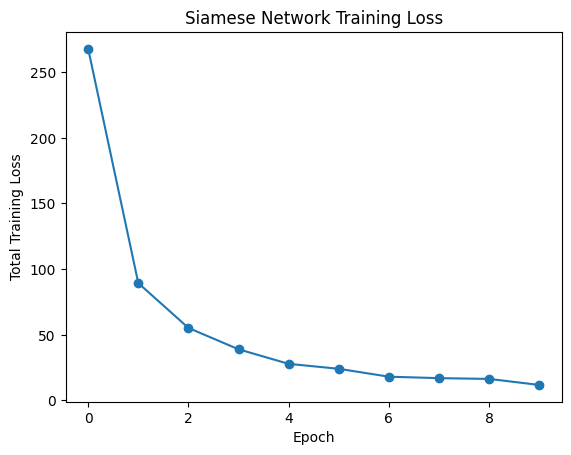

In [3]:
### =========== MODEL TRAINING

#store the losses
train_losses = []

# --- Training for 5 epochs
for epoch in range(10):
    # Initialize loss accumulator for this epoch
    total_loss = 0  # Initialize loss accumulator for this epoch
    # loop over the Siamese dataset
    for img1, img2, pair_label in dataloader_tr:
        # Move images and labels to GPU
        img1, img2, pair_label = img1.cuda(), img2.cuda(), pair_label.cuda()
        # Zero the gradients from previous step
        optimizer.zero_grad()
        # compute embeddings for both images
        output1, output2 = model(img1, img2)
        # Compute the batch's contrastive loss
        loss_contrast = crit(output1, output2, pair_label)
        # Backpropagate to compute gradients
        loss_contrast.backward()
        # Accumulate the loss
        total_loss += loss_contrast.item()
        # Update the network weights (based on gradients)
        optimizer.step()
    #append the loss
    train_losses.append(total_loss)
    # Print average epoch's loss
    print(f"Epoch {epoch} Loss is {total_loss:.2f}")
    #plot epoch vs loss


# --- Plot Loss after training
plt.plot(range(len(train_losses)), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Total Training Loss')
plt.title('Siamese Network Training Loss')
plt.show()


Epoch 0 Loss is 5.66

Epoch 1 Loss is 5.68

Epoch 2 Loss is 4.67

Epoch 3 Loss is 5.37

Epoch 4 Loss is 5.41


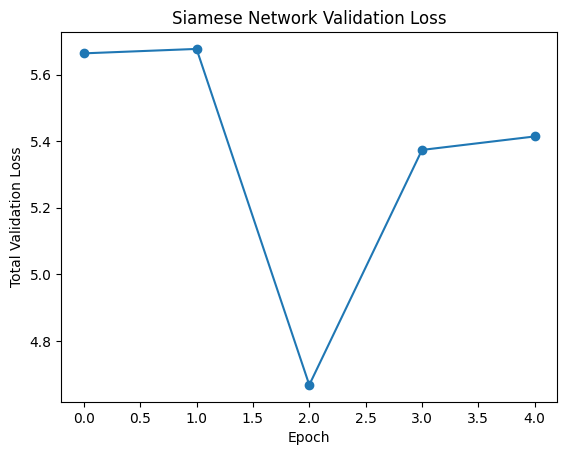

In [4]:
### =========== MODEL VALIDATION

#set the validation dataset
# DataLoader (for validation): loads 64 image pairs at a time, no shuffling for validation, uses 8 worker threads to speed up training
dataloader_val = DataLoader(siamese_val, num_workers=8, batch_size=64)

#store the losses
val_losses = []

# Set model to evaluation mode
model.eval()

#disable gradient computation (faster)
with torch.no_grad():
# loop training for 5 epochs
  for epoch in range(5):
      # Initialize loss accumulator for this epoch
      val_total_loss = 0  # Initialize loss accumulator for this epoch
      # loop over the Siamese dataset
      for img1, img2, pair_label in dataloader_val:
          # Move images and labels to GPU
          img1, img2, pair_label = img1.cuda(), img2.cuda(), pair_label.cuda()
          # Zero the gradients from previous step
          optimizer.zero_grad()
          # compute embeddings for both images
          output1, output2 = model(img1, img2)
          # Compute the batch's contrastive loss
          val_loss_contrast = crit(output1, output2, pair_label)
          # Accumulate the loss
          val_total_loss += val_loss_contrast.item()
      #append the loss
      val_losses.append(val_total_loss)
      # Print average epoch's loss
      print("")
      print(f"Epoch {epoch} Loss is {val_total_loss:.2f}")


# --- Plot Loss after validation
plt.plot(range(len(val_losses)), val_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Total Validation Loss')
plt.title('Siamese Network Validation Loss')
plt.show()

In [5]:
### =========== MODEL TUNING

# re-set the model in training mode
model.train()

#tuning model with batch
tuning_model = SiameseNetworkBatch().cuda()

#if more training is needed, set the model in training mode
model.train()

#define various margins
margin = [1.0, 1.5, 2.0]
#store results
tuning = {}

#set a loop to loop over different margins
for mar in margin:
  print("=======================================")
  print("")
  print(f"Training with margin = {mar}")
  print("")
  # Reinitialize model for each margin
  #tuning model with batch
  tuning_model = SiameseNetworkBatch().cuda()
  #Reinitialize optimizer for each margin
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  # Initialize loss function
  crit = ContrastLoss(margin=mar)

  #store the losses
  tuning_losses = []

  # loop training for 5 epochs
  for epoch in range(5):
      # Initialize loss accumulator for this epoch
      total_loss = 0  # Initialize loss accumulator for this epoch
      # loop over the Siamese dataset
      for img1, img2, pair_label in dataloader_tr:
          # Move images and labels to GPU
          img1, img2, pair_label = img1.cuda(), img2.cuda(), pair_label.cuda()
          # Zero the gradients from previous step
          optimizer.zero_grad()
          # compute embeddings for both images
          output1, output2 = model(img1, img2)
          # Compute the batch's contrastive loss
          loss_contrast = crit(output1, output2, pair_label)
          # Backpropagate to compute gradients
          loss_contrast.backward()
          # Accumulate the loss
          total_loss += loss_contrast.item()
          # Update the network weights (based on gradients)
          optimizer.step()

      #append the loss
      tuning_losses.append(total_loss)

      # Print average epoch's loss
      print("=======================================")
      print(f"Epoch {epoch} Loss is {total_loss:.2f}")

      # validation after training with this margin
      val_loss = evaluate(model, dataloader_val, crit)
      print(f"Validation loss: {val_loss:.4f}")

      # store both training and validation results
      tuning[mar] = {
          "train_losses": tuning_losses,
          "val_loss": val_loss
    }


Training with margin = 1.0

Epoch 0 Loss is 3.92
Validation loss: 0.0099
Epoch 1 Loss is 2.68
Validation loss: 0.0134
Epoch 2 Loss is 2.29
Validation loss: 0.0102
Epoch 3 Loss is 2.10
Validation loss: 0.0169
Epoch 4 Loss is 3.01
Validation loss: 0.0135

Training with margin = 1.5

Epoch 0 Loss is 5.01
Validation loss: 0.0326
Epoch 1 Loss is 6.38
Validation loss: 0.0326
Epoch 2 Loss is 3.98
Validation loss: 0.0230
Epoch 3 Loss is 3.38
Validation loss: 0.0283
Epoch 4 Loss is 2.72
Validation loss: 0.0274

Training with margin = 2.0

Epoch 0 Loss is 5.46
Validation loss: 0.0556
Epoch 1 Loss is 5.42
Validation loss: 0.0595
Epoch 2 Loss is 7.70
Validation loss: 0.0440
Epoch 3 Loss is 5.24
Validation loss: 0.0432
Epoch 4 Loss is 6.28
Validation loss: 0.0286


In [ ]:
#define the drive path
#drive.mount('/content/drive')
#Save permanently
torch.save(tuning_model.state_dict(), "tuning_siamese_model.pt")
#print to confirm it
print("✅ Best model saved as 'tuning_siamese_model.pt'")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Best model saved as 'tuning_siamese_model.pt'


In [ ]:
### =========== FINAL RE-TRAINING ON THE WHOLE TRAINING SET

## DATA & MODEL SETUP
# Initialize the top-performing model again

#Option1: if tuning cell was run
#tun_model = tuning_model.cuda()

#Option2: if tuning cell was not run
tun_model = SiameseNetworkBatch().cuda()
#drive.mount('/content/drive')
tun_model.load_state_dict(torch.load("tuning_siamese_model.pt"))
print("✅ Tuned model successfully loaded from 'tuning_siamese_model.pt'")

# Define optimizer
tun_optimizer = optim.Adam(tun_model.parameters(), lr=0.001)
# Set loss function with the best margin (1.0)
crit = ContrastLoss(margin=1.0)
#entire training dataset
siamese_training = SiameseData(data_training, transform)
#loader
dataloader_training = DataLoader(siamese_training, batch_size=64, shuffle=True, num_workers=8)

## RE-TRAIN
# Set model in training mode
tun_model.train()
print("")
#re-train the final model on the full set (updating weights for one last time)
for epoch in range(10):
    total_loss = 0
    for img1, img2, pair_label in dataloader_training:
        img1, img2, pair_label = img1.cuda(), img2.cuda(), pair_label.cuda()

        tun_optimizer.zero_grad()
        output1, output2 = tun_model(img1, img2)
        loss = crit(output1, output2, pair_label)
        loss.backward()
        tun_optimizer.step()

        total_loss += loss.item()
    #show the epoch's loss
    print(f"Epoch {epoch} Training Loss: {total_loss:.4f}")
    print("")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Tuned model successfully loaded from 'tuning_siamese_model.pt'

Epoch 0 Training Loss: 76.5263

Epoch 1 Training Loss: 44.5613

Epoch 2 Training Loss: 29.7770

Epoch 3 Training Loss: 20.0709

Epoch 4 Training Loss: 13.8926

Epoch 5 Training Loss: 12.6677

Epoch 6 Training Loss: 9.6995

Epoch 7 Training Loss: 8.9209

Epoch 8 Training Loss: 6.1329

Epoch 9 Training Loss: 4.9793



In [ ]:
#define the drive path
#drive.mount('/content/drive')
#Save permanently
torch.save(tun_model.state_dict(), "Siamese_model.pt")
#print to confirm it
print("✅ Best model saved as 'Siamese_model.pt'")

✅ Best model saved as 'Siamese_model.pt'


In [12]:
### =========== TESTING

# Set-up testing DataLoader
dataloader_test = DataLoader(siamese_tt, batch_size=64, shuffle=False, num_workers=8)

# Set model to evaluation mode (disable dropout and batch normaliz)
tun_model.eval()
#list to store the losses
val_losses = []

#disable gradient comput as in testing phase (speed up computation)
with torch.no_grad():
  #loop over batches
    for img1, img2, pair_label in dataloader_test:
      #move all to GPU
        img1, img2, pair_label = img1.cuda(), img2.cuda(), pair_label.cuda()
        #forward pass through the model to get embedding
        output1, output2 = tun_model(img1, img2)
        #compute contrastive loss
        loss = crit(output1, output2, pair_label)
        #append the loss
        val_losses.append(loss.item())

# Compute and print the average test loss over all batches
print(f"Test loss: {sum(val_losses)/len(val_losses):.4f}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test loss: 0.0120


In [11]:
### =========== ROC - AUC

#initialize empty lists to store true labels & unpredicted similarities
y_true, y_score = [], []

#disable gradient computation
with torch.no_grad():
  #loop through the test dataset
    for img1, img2, label in dataloader_test:
      #move to GPU
        img1, img2 = img1.cuda(), img2.cuda()
        #pass imgs through the trained CNN
        output1, output2 = tun_model(img1, img2)
        #compute Euclid distance betweem embeddings (smaller = more similar)
        distances = F.pairwise_distance(output1, output2)
        #store the ground-truth labels (1 = same, 0 = different)
        y_true.extend(label.numpy())
        #store the model's predicted distances (usead as similarity scores)
        y_score.extend(distances.cpu().numpy())

# Compute ROC AUC
#compute false positive (fpr), trupe positive (tpr) and threshold using
#ground-truth labels and predicted distances
fpr, tpr, _ = roc_curve(y_true, y_score)
# Compute the Area Under the ROC Curve (AUC)
# Higher AUC means better discrimination between similar/dissimilar pairs
roc_auc = auc(fpr, tpr)
#print it
print("")
print(f"ROC AUC: {roc_auc:.4f}")
print("")
#show an evaluation
if roc_auc > 0.99:
  print("The model does a great job in discriminating between classes, as in the")
  print(f"{roc_auc *100:.2f}% of the cases it correctly assigns a higher similairty score to")
  print("matching pairs than to non-matching pairs.")



ROC AUC: 0.9979

The model does a great job in discriminating between classes, as in the
99.79% of the cases it correctly assigns a higher similairty score to
matching pairs than to non-matching pairs.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


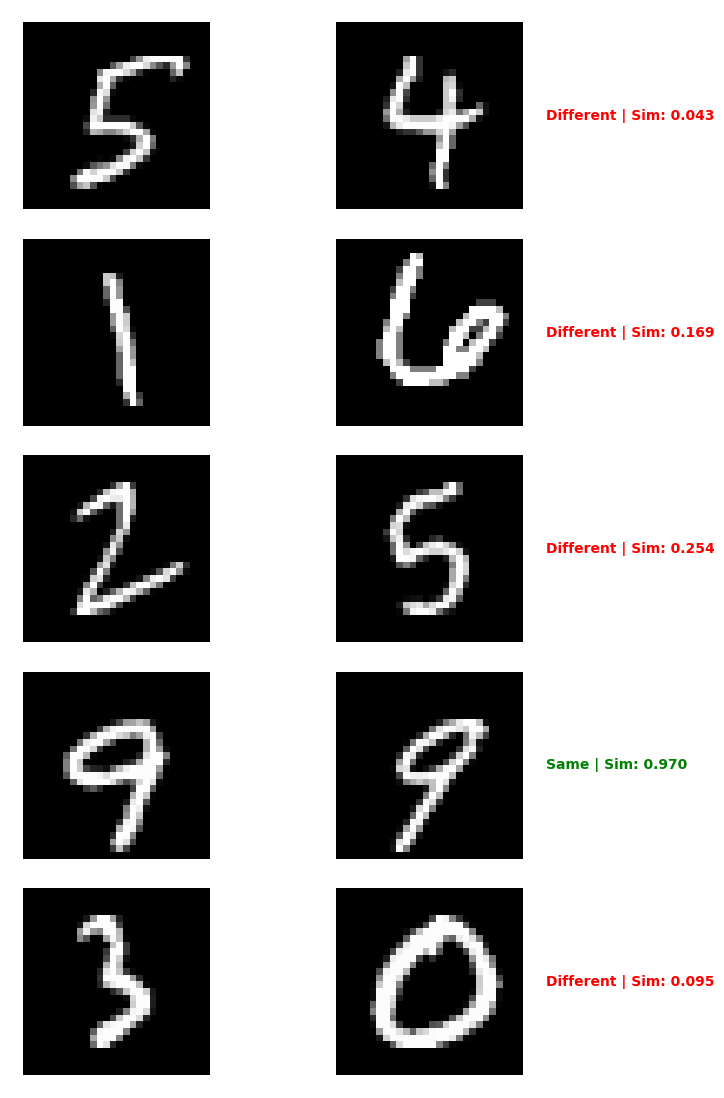

In [ ]:
### =========== ACTUAL IMGS COMPARISON DEMO

#set model to evaluation
tun_model.eval()

#get a test set's batch
data_iter = iter(dataloader_test)
img1_batch, img2_batch, labels = next(data_iter)
#move to gpu
img1_batch, img2_batch = img1_batch.cuda(), img2_batch.cuda()

#compute embeddings and similarity scores (no gradient computation)
with torch.no_grad():
  #compute embeddings
    output1, output2 = tun_model(img1_batch, img2_batch)
    #compute similarities [within 0-1]
    similarities = compute_similarity(output1, output2)

# Move img back to CPU and convert to numpy array
img1_batch = img1_batch.cpu().numpy()
# Move img back to CPU and convert to numpy array
img2_batch = img2_batch.cpu().numpy()
# Move img back to CPU and convert to numpy array
similarities = similarities.cpu().numpy()
#add labels
labels = labels.numpy()

# Create a figure with 5 rows and 2 columns for displaying image pairs
fig, axes = plt.subplots(5, 2, figsize=(8, 14)) #8 = width, 14 = height
# Adjust spacing between subplots
fig.subplots_adjust(wspace=0.02, hspace=0.02)

#loop over the axes to display 5 random img pairs
for i, ax_pair in enumerate(axes):
    #pick random index from the batch
    idx = random.randint(0, len(img1_batch) - 1)
    #pick its similarity
    sim = similarities[idx]
    #check if pair si matching
    true_label = "Same" if labels[idx] == 0 else "Different"
    #coloring (green = match, red = not match)
    color = "green" if true_label == "Same" else "red"

    #add white borders (clear splitting)
    img1 = np.pad(img1_batch[idx][0], pad_width=2, mode='constant', constant_values=1)
    img2 = np.pad(img2_batch[idx][0], pad_width=2, mode='constant', constant_values=1)

    #plot img 1 (left corner)
    ax_pair[0].imshow(img1, cmap="gray")
    ax_pair[0].axis("off")
    #plot img2 (right corner)
    ax_pair[1].imshow(img2, cmap="gray")
    ax_pair[1].axis("off")

    # Add text on the right of the second image
    ax_pair[1].annotate(
        f"{true_label} | Sim: {sim:.3f}",
        xy=(1.05, 0.5), xycoords='axes fraction',
        ha='left', va='center', #vertically centered
        fontsize=10, fontweight='bold', color=color #color matching
    )
#show the plot
plt.show()


Saving 721PB1007-1-430x430.jpg.webp to 721PB1007-1-430x430.jpg (9).webp


/tmp/ipython-input-3854590661.py:75: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


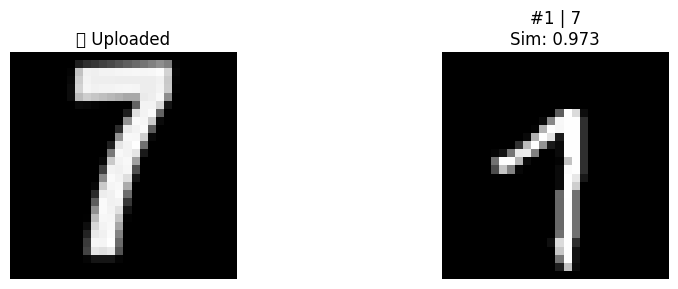

The uploaded img is a 7 


In [ ]:
### =========== MATCHING IMAGE & NUMBER IDENTIFICATION

#prompt to upload an image file (showing a 1-digit number)
uploaded = files.upload()

#load and preprocess the uploaded image
#Note. MNIT imgs are black back-white digits -> need to transform the uploaded img
#into this layout
for filename in uploaded.keys():
  #load uploaded img from memory
    img = Image.open(io.BytesIO(uploaded[filename]))  # load image
    #convert to grayscale (MNIST files are grayscale)
    gray_img = img.convert("L")  # single channel
    #convert to numpy array
    gray_np = np.array(gray_img)
    #if img's back is bright (white) invert colors
    if np.mean(gray_np) > 127:
        gray_img = ImageOps.invert(gray_img)
    #resize to MNIST standards (28x28 pixels)
    gray_img = gray_img.resize((28, 28))
    #convert to tensor and add batch dimension (for model input)
    user_img = transforms.ToTensor()(gray_img).unsqueeze(0).cuda()

    #compute embedding of the uploaded image thanks to the CNN
    tun_model.eval() #set model in evaluation mode
    #no gradient computation
    with torch.no_grad():
        user_embed = tun_model.forward_once(user_img)

    #arrange a pool of test imgs for comparison
    #compare against entire test set
    n_samples = len(data_tt)
    #store img tensors
    test_imgs = []
    #store true digits labels
    test_labels = []
    #store embeddings
    test_embeds = []

    #loop over all test imgs
    for i in range(n_samples):
      #extract test img and its label
        test_img, test_label = data_tt[i]
        #apply same pre-processing (re-size + tesnor conversion)
        test_img_proc = transforms.ToTensor()(test_img.resize((28, 28)))
        #save pre-processed img
        test_imgs.append(test_img_proc.squeeze().numpy())
        #and its label
        test_labels.append(test_label)
        #compute embedding for the test img
        with torch.no_grad():
            test_embeds.append(tun_model.forward_once(test_img_proc.unsqueeze(0).cuda()))

    #compute euclidean distance between uploaded img and all test imgs
    distances = [F.pairwise_distance(user_embed, e).item() for e in test_embeds]

    #Show the most similar img (smaller distance)
    #Note. tweak this to show the n-top similar images
    top_idx = np.argsort(distances)[:1]
    top_matches = [test_imgs[i] for i in top_idx]
    top_labels = [test_labels[i] for i in top_idx]
    #convert distance into similarity score (higher = more similar)
    top_scores = [np.exp(-distances[i]) for i in top_idx]

    #display the upload img + its closest match
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    #show uploaded img
    axes[0].imshow(user_img.cpu().squeeze().numpy(), cmap="gray")
    axes[0].set_title("🔹 Uploaded")
    axes[0].axis("off")
    #show the most similar test img
    for j in range(1):
        axes[j+1].imshow(top_matches[j], cmap="gray")
        axes[j+1].set_title(f"#{j+1} | {top_labels[j]}\nSim: {top_scores[j]:.3f}")
        axes[j+1].axis("off")
    #show plot
    plt.tight_layout()
    plt.show()

    #print the output
    print("=======================================")
    print(f"The uploaded img is a {top_labels[j]}")
    print("=======================================")
